## Table of Contents:
* 0\. [PhaseRetrieval](#phaseretrieval)
    * 0.1\. [Source code](#source-code)
    * 0.3\. [Requirements](#requirements)
    * 0.4\. [License](#license)
* 1\. [Image processing for phase retrieval](#image-processing-for-phase-retrieval) 
    * 1.1\. [Loading data](#loading-data)
        * 1.1.1\. [Object-domain images](#object-domain-images)
        * 1.1.2\. [Fourier-domain images](#fourier-domain-images)
    * 1.2\. [Processing in the object domain](#processing-in-the-object-domain)
        * 1.2.1\. [Background subtraction](#background-subtraction)
        * 1.2.2\. [Centering using watershed algorithm](#centering-using-watershed-algorithm)
        * 1.2.3\. [Resampling](#resampling)        
    * 1.3\. [Processing in the Fourier domain](#processing-in-the-fourier-domain)
        * 1.3.1\. [Zero-padding and centering](#zero-padding-and-centering)
        * 1.3.2\. [Subtraction of background](#subtraction-of-background)
        * 1.3.3\. [Renormalisation (Parseval's theorem)](#renormalisation)
    * 1.4\. [Saving processed images](#saving-processed-images)
* 2\. [Phase retrieval from two intensity measurements](#phase-retrieval-from-two-intensity-measurements)
* 3\. [Phase retrieval from the modulus of Fourier transform data](#phase-retrieval-from-the-modulus-of-Fourier-transform-data) 

In [1]:
#remove_cell
import sys
import glob,os
from matplotlib import pyplot as plt
import numpy as np


datapath = '/Users/Pavel/Documents/repos/PhaseRetrieval/docs/data'
sourcepath = '/Users/Pavel/Documents/repos/PhaseRetrieval/'

sys.path.insert(0,sourcepath)
sys.path.insert(0,datapath)



#automatically track changes in the source code
%load_ext autoreload
%autoreload 2

# PhaseRetrieval <a class="anchor" id="phaseretrieval"></a>

Author: Dr. Pavel Kliuiev

PhaseRetrieval is a 'work-in-progress' Python-based framework for solution of the phase problem. 

The phase retrieval problem is a mathematical problem of recovering an unknown object distribution (an unkwown function) from the known modulus of its Fourier transform. Phase retrieval algorithms make use of available information (such as real- or complex-valuedness of the object or its low-resolution optical image). The problem is widely encountered in imaging and signal processing and its applications range from adaptive optics for large space telescopes and 3D microscopic imaging of cells to imaging through turbulent atmosphere and visualisation of the valence orbitals of organic molecules. 

Prior to the application of phase retrieval algorithms, the data must be pre-processed. Section "Image processing for phase retrieval" lists typical steps needed to do such a pre-processing.

Section "Phase retrieval" (work in progress) provides a detailed description of the steps for the recovery of the object distributions either when only Fourier modulus is available or in case of availability of both the Fourier- and the object-domain data.

## Source code  <a class="anchor" id="source-code"></a>

The source code is located under https://github.com/pkliui/PhaseRetrieval

## Requirements  <a class="anchor" id="requirements"></a>

The software was tested using the following versions of the packages:

* ddt 1.3.1
* numpy 1.15.4    
* python 3.6.8
* pandas 0.24.2
* scipy 1.1.0
* scikit-image 0.16.2


## License  <a class="anchor" id="license"></a>

The source code is released under the 3-clause BSD license.

# Image processing for phase retrieval <a class="anchor" id="image-processing-for-phase-retrieval"></a>

## Loading data <a class="anchor" id="loading-data"></a>

### Object-domain images <a class="anchor" id="object-domain-images"></a>

Prior to the application of phase retrieval algorithms, input images must be pre-processed. From phase retrieval perspective, we consider the simplest case when both object- and Fourier-domain images are available to the user. The user is interested in recovering the phase information in the object domain.

In this case, image pre-processing can be done with the classes ```RSpaceImage``` and ```KSpaceImage``` for object- and Fourier-domain images, respectively. We start with the class ```RSpaceImage``` for  object-domain images which is initialised as follows.

In [2]:
from PhaseRetrieval.classes.rspaceimage import RSpaceImage
print(RSpaceImage.__init__.__doc__)


        Initializes the object-domain image class

        ---
        Parameters
        ---
        filename: str, optional
            Path used to load the image.
            If None, an empty class is created.
            If `image` argument is provided, the image will be initialized from the `image` argument.
            Default is None.
        delimiter: str, optional
            Delimiter used in the csv file (need to be specified if data are loaded from a csv file).
            If None, an empty class is created.
            Default is None.
        image : ndarray, optional
            2D array to initialize the image.
            If None, an empty class is created.
            Default is None.
        image_apodization_filter: ndarray, optional
            2D array to initialize the thresholded version of the image (i.e. image apodization filter).
            If None, an empty class is created.
            Default is None.
        


#### Read data <a class="anchor" id="read-data"></a>

The image is loaded by specifying keyword arguments ```filename```, which is the full path to an image to be loaded, and ```delimiter```, which, in case of images loaded from csv files, is a delimiter. In our case, we specified the datapath in the first cell and joined it with the filename.

There is also an option to read images from tif files. In this case, no delimiter needs to be specified. Only the full path to the file.

The loaded image can be plotted using ```plot_image``` method of ```RSpaceImage```class. To zoom in to the image, set the keyword argument ```zoom``` to any float > 1. The input images are typically not centred in the computational domain.

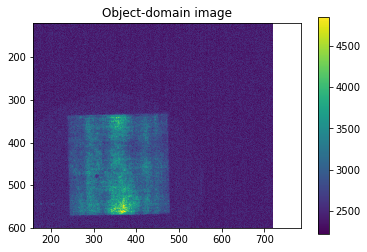

In [3]:
rs = RSpaceImage(filename=os.path.join(datapath,'RS.csv'),
                 delimiter='\t')
rs.plot_image(zoom=1.5)

#### Rotation and flipping <a class="anchor" id="rotation-and-flipping"></a>

Sometimes, in the data acquisition process, mutual orientation of the object- and Fourier-domain images can be changed (i.e. horizontal and vertical axes in object-domain images can be either flipped or rotated with respect to those in Fourier-domain images). 

The data thus must be rotated counter-clockwise and/or flipped upside-down.

Rotation is done by ```rotate_image```method, ```times_rot=1```to rotate only once and ```estimate_only```is set to ```True```to only estimate how the image will look like if rotated and to ```False```to perform the rotation. The method roates the images counter-clockwise by default. To change the direction of the rotation, either set the keyword argument  ```axes```to ```(1,0)``` or just set the number of rotations to ```times_rot=3```.



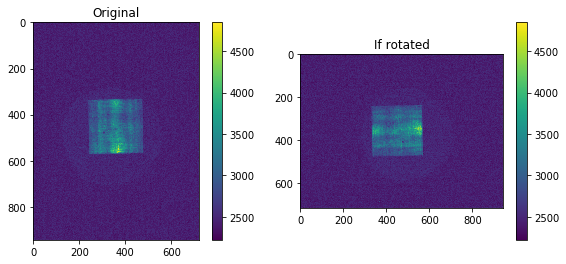

In [4]:
rs.rotate_image(times_rot=1, 
                estimate_only=True)

Input image was rotated


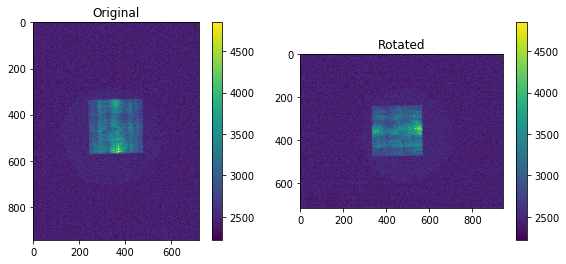

In [5]:
rs.rotate_image(times_rot=1, 
                estimate_only=False)

The flipping is done using ```flip_image```method. The method flips the image upside-down by default. To flip left-right, set the keyword argument ```axis```to ```0```. Set ```estimate_only```to ```True```to only estimate how the image will look like if flipped and to ```False```to perform the flipping.

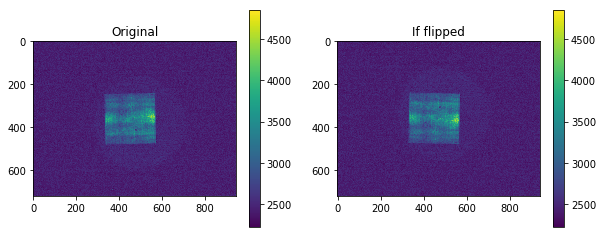

In [6]:
rs.flip_image(estimate_only=True)

Input image was flipped


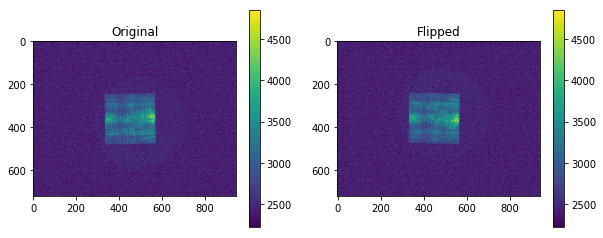

In [7]:
rs.flip_image(estimate_only=False)

### Fourier-domain images <a class="anchor" id="fourier-domain-images"></a>

The class for Fourier-domain images ```RSpaceImage``` is initialised equivalently.

In [8]:
from PhaseRetrieval.classes.kspaceimage import KSpaceImage
print(KSpaceImage.__init__.__doc__)


        Initializes Fourier-domain image class

        ---
        Parameters
        ---
        filename: str, optional
            Path used to load the image.
            If None, an empty class is created.
            If `image` argument is provided, the image will be initialized from the `image` argument.
            Default is None.
        delimiter: str, optional
            Delimiter used in the csv file (need to be specified if data are loaded from a csv file).
            If None, an empty class is created.
            Default is None.
        image : ndarray, optional
            2D array to initialize the image.
            If None, an empty class is created.
            Default is None.
        renorm_factor : float
            Renormalisation factor to fulfill Parseval's theorem
            If None, an empty class is created.
            Default is None.
        


#### Read data <a class="anchor" id="read-data"></a>

The data is read by specifying the ```filename``` keyword argument. To plot and zoom in to the Fourier-domain image, set the keyword argument ```zoom``` in ```plot_image```method of ```KSpaceImage```class to a number > 1. One may also set ```log_scale = True``` to plot the image in logarithmic scale and ```log_scale = False```to plot it in linear scale.

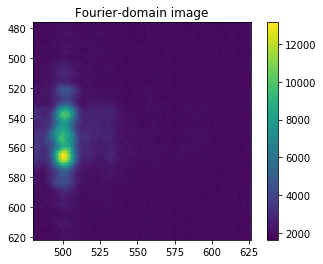

In [25]:
ks = KSpaceImage(filename=os.path.join(datapath,'KS.csv'),
                 delimiter='\t')
ks.plot_image(zoom=7.5, 
              log_scale = False)

#### Rotation and flipping <a class="anchor" id="rotation-and-flipping"></a>

Rotation is done by ```rotate_image```method, ```times_rot=1```to rotate only once and ```estimate_only```is set to ```True```to only estimate how the image will look like if rotated and to ```False```to perform the rotation. The method roates the images counter-clockwise by default. To change the direction of the rotation, either set the keyword argument  ```axes```to ```(1,0)``` or just set the number of rotations to ```times_rot=3```.



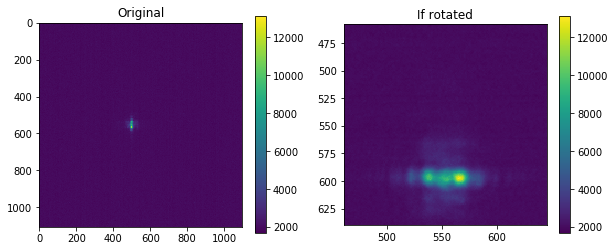

This is how the image looks like if rotated.


In [10]:
ks.rotate_image(times_rot=1, 
                zoom=6, 
                estimate_only=True)

Input image was rotated


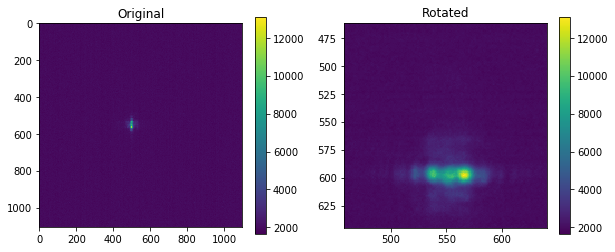

In [11]:
ks.rotate_image(times_rot=1, 
                zoom=6, 
                estimate_only=False)

The flipping is done using ```flip_image```method. The method flips the image upside-down by default. To flip left-right, set the keyword argument ```axis```to ```0```. Set ```estimate_only```to ```True```to only estimate how the image will look like if flipped and to ```False```to perform the flipping.

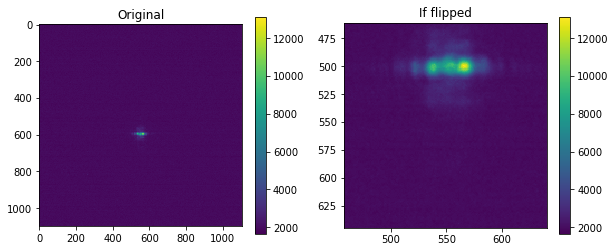

In [12]:
ks.flip_image(zoom=6, 
              estimate_only=True)

Input image was flipped


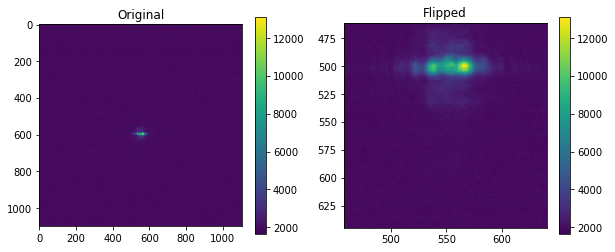

In [13]:
ks.flip_image(zoom=6, 
              estimate_only=False)

Similarly to the object-domain image, the Fourier data are de-centred too and hence must be placed in the middle of the computational domain.

## Processing in the object domain <a class="anchor" id="processing-in-the-object-domain"></a>

We start with the processing in the object domain.

### Background subtraction <a class="anchor" id="background-subtraction"></a>

The Fourier transform of white noise is noise. Thus, one may expect that by adding noise in Fourier domain we simply add noise to the corresponding object-domain distribution. In phase retrieval, however, the noise is recorded together with the intensity distribution in Fourier domain (diffraction pattern). And the corresponding object distribution is confined to a certain area surrounded by zeros, which is called object support. The application of such a constraint in the object domain does not allow noise in Fourier data to get translated into noise in object-domain data. As a result, noise in both domains must be subtracted as the quality and the resolution of the reconstruction highly depend on the presence of noise in the input images.

We simplify the substraction procedure by assuming that the noise distribution is quasi-constant throughout the whole image. The background can be subtracted using ```subtract_background```method of class ```RSpaceImage```.

Set ```estimate_only=True``` to estimate how the image will look like after the background subtraction. Plotting in logarithmic scale makes it easier to see whether the counts' value is high enough.

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:428: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(im_bgfree))


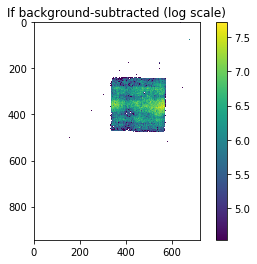

This is how the image looks like if the background were subtracted.
Background was set to  2610


In [14]:
rs.subtract_background(counts=2610, 
                       estimate_only=True, 
                       zoom=1.0,
                       log_scale=True)

When one is satisfied with the result, set ```estimate_onyl=False``` and the specified number of counts will be subtracted from the image.

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:448: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(self.image))


Plotted in log scale


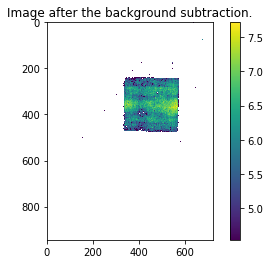

Background of 2610 counts has been subtracted.


In [15]:
rs.subtract_background(counts=2610, 
                       estimate_only=False, 
                       log_scale=True)

### Centering using watershed algorithm<a class="anchor" id="centering-using-watershed-algorithm"></a>

The centering can be done using ```centre_image_watershed``` method of class ```RSpaceImage```. We use watershed algorithm to locate the boundaries of the square-shaped object distribution, compute its centre of mass and, finally, centre it in the computational domain. There is an option to pad the image with zeros to a number of pixels higher than the original one (to make the number of pixels in both dimensions equal, for example). The method also returns information about the linear size of the pixel in the object domain, which will be used later on in the processing. The object's boundaries may optionally be apodized with a gaussian filter.

In [16]:
print(rs.centre_image_watershed.__doc__)


        Centers the object-domain image using watershed algorithm (the existence of only a single blob is assumed).
        Finds its physical linear pixel size.
        Completes zero-padding of the original image to a specified linear number of pixels
        Applies an apodization filter to smooth boundaries of the object distribution (optional)

        ---
        Parameters
        ---
        linear_object_size: float, optional
            Physical linear size of the (non-zero-valued) input object distribution, in micrometers.
            Default is 100.
        npixels_pad: int, optional
            Linear number of pixels in the zero-padded object-domain image.
            Default is 2000.
        apodization: bool, optional
            If True, the boundaries of the object distribution will be smoothed using Gaussian filter
            with standard deviation = 1 and truncation of the filter's boundaries to 2
            (fixed at the moment, but may/should be changed in the

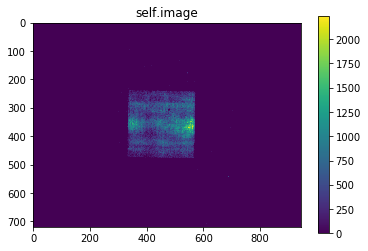

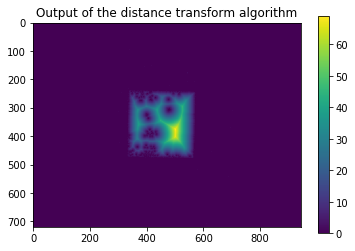

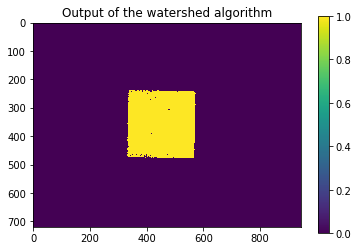

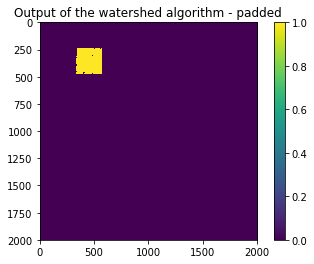

Input and watershed images have been padded to  2000 X 2000 pixels.


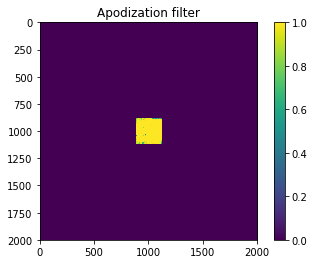

Centred.
Apodization filter has been applied.
Linear pixel size is  426.0 nm


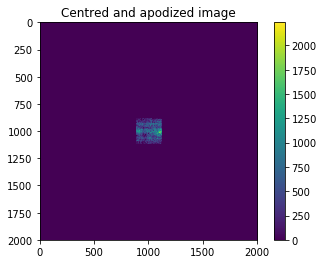

In [17]:
rs.centre_image_watershed(linear_object_size=100,  
                          npixels_pad=2000, 
                          apodization=True)

### Resampling <a class="anchor" id="resampling"></a>

The pixel sizes in the object domain, $\Delta r$ [m], and Fourier domain, $\Delta k$ [rad/m], are connected as 

$\Delta r \Delta k = \frac{2\pi}{N}$,                      (1)

where $N$ is the linear pixel number.  If one aims at using both object- and Fourier-domain images in phase retrieval, equation (1) must be fulfilled. Typically, this is not the case for raw data and either of images must be resampled to ensure correct application of the discrete Fourier transform. We go on for the resampling of object-domain images.

Resampling can be done with ```resample_image```method of class ```RSpaceImage```. 

In [18]:
print(rs.resample_image.__doc__)


        Resamples object-space image to equalise its pixel size to the one set by
        digital Fourier transform and the pixel size in the experimental Fourier-space image

        ---
        Parameters
        ---
        fieldofview: int, optional
            One half of field of view in Fourier-space, in degrees
            Default is ±17°, i.e. fieldofview = 17
        npixels_kspace: int, optional
            One half of linear number of non-zeros-valued pixels in experimental Fourier-space image to be used together with the real-space image
            (= corresponds to the linear number of pixels within the 1/2 of field of view)
            Default is 500
        pixelsize_dr0: int, optional
            Pixel size in experimental object-domain image, in nm.
            If it is None, the value will be read from metadata (saved to metadata after centering and segmentation of the image).
            If the value in metadata is None, there will be an error message.
           

From calibration data (not shown), the non-zero-valued linear number of pixels in the Fourier-domain image is ```npixels_kspace = 726```. This number corresponds to the optical field of view ```fieldofview = ±17°```. The pixel size can be estimated from the watershed segmentation.

In [19]:
rs.resample_image(fieldofview = 17, 
                 npixels_kspace = 726/2,
                 pixelsize_dr0 = 426,
                 lambd = 880, 
                 estimate_only = True)

npixels_final = 2565
estimating the downsampling ratio...
Downsampling ratio = 1.0


The downsampling ratio is the linear number of pixels in the input object-domain image needed to create a single pixel in the down-sampled object-domain image.

In [20]:
rs.resample_image(fieldofview = 17, 
                 npixels_kspace = 726/2,
                 pixelsize_dr0 = 426,
                 lambd = 880, 
                 estimate_only = False)

npixels_final = 2565
input image shape is  2000 X 2000
resampling object domain image...
image has been resampled and its current shape is (2000, 2000)
image has been resampled with the downsampling ratio = 1.0 and zero-padded to npixels_final X npixels_final= 2564 X 2564 pixels


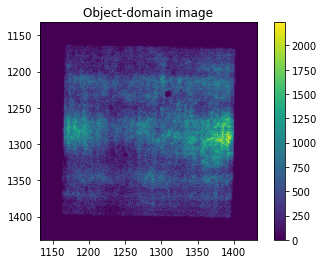

In [21]:
rs.plot_image(zoom=8.5)

## Processing in the Fourier domain <a class="anchor" id="processing-in-the-fourier-domain"></a>

### Zero-padding and centering <a class="anchor" id="zero-padding-and-centering"></a>

The image can be centred using ```centre_image```method of ```KSpaceImage```class. This method finds local maximal within a specified region of interest (ROI).



In [22]:
print(ks.centre_image.__doc__)


        Centers the Fourier-domain image whose centre is located at one of its local maxima
        Completes zero-padding of the original image to a specified linear number of pixels

        ---
        Parameters
        ---
        roi: tuple, optional
            Region of interest (ROI) used to search for local maxima.
            Default is (0,10,0,10).
        centre: tuple, optional
            Centre of the image.
            Default is (1,1), which must be changed by user once the centre of the image (one of the local maxima) is found.
        min_distance, int, optional
            Minimal distance between the local maxima
            Must be tuned by user to make the search most effective.
            Default is 10.
        threshold_abs: float, optional
            Minimum intensity of peaks.
            Default is 0.
        num_peaks: int, optional
            Maximum number of peaks.
            When the number of peaks exceeds num_peaks, return num_peaks peaks based 

The image can be centred using ```centre_image```method of ```KSpaceImage```class. This method finds local maximal within a specified region of interest (ROI).

* Set ```estimate_only = True```. This will allow tuning the parameters of the procedure and to find the local maximum which, in user's opinion, corresponds to the centre of the image. Setting ```estimate_only = Fals``` will use the coordinates specified in ```centre```argument and will irreversibly centre the image. 

* At this point, ```centre```argument can be arbitrary.

* Set the region of interest  (ROI) ```roi```argument. The first two numbers are the coordinates of the bottom left corner, the last two are of the top right corner of the ROI box.

* Set the other arguments.

* ```npixels_pad```must be set to linear number of pixels in the object-domain image after it was resampled.

* Run the cell and the procedure will find local maxima and will show their coordinates on the plot. If you think the right local maximum was found, copy its coordinates to ```centre```argument and set ```estimate_only=False```. 

* Run the cell. The procedure will centre the image and pad it to around with zeros to a linear number of pixels specified  in ```npixels_pad```.

* If the desired local maximum was not found, try changing ```min_distance```, ```threshold_abs``` and ```num_peaks```arguments.

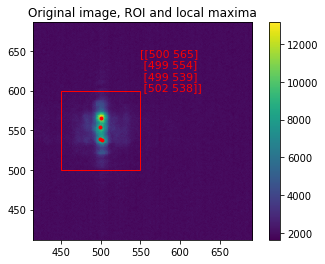

Input image was padded to  2564 X 2564 pixels.


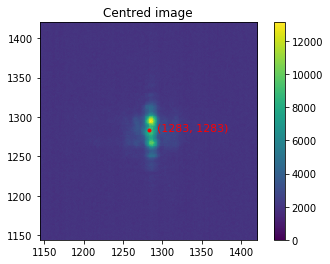

In [27]:
ks.centre_image(estimate_only = False, 
                centre = (499, 554), 
                roi=(450,500,550,600), 
                min_distance = 5, 
                threshold_abs = 5000, 
                num_peaks = 4,  
                zoom = 4, 
                npixels_pad = 2564)

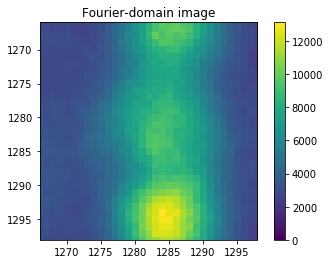

In [28]:
ks.plot_image(zoom=80)

Optionally, the image can be centred manually by specifying the coordinates of its centre using ```centre_image_manually```method.

In [364]:
ks.centre_image_manually(manual_centroid=(499, 554), npixels_final=2000)

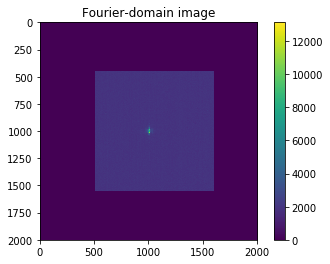

In [366]:
ks.plot_image()

### Subtraction of background <a class="anchor" id="subtraction-of-background"></a>

Similarly, we assume that the noise distribution is quasi-constant throughout the whole Fourier-domain image. The background is subtracted using ```subtract_background```method of class ```KSpaceImage```.

Set ```estimate_only=True``` to estimate how the image will look like after the background subtraction. Plotting in logarithmic scale makes it easier to see whether the counts' value is high enough.

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/kspaceimage.py:487: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(im_bgfree))


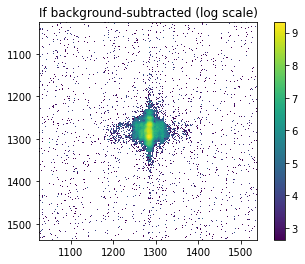

This is how the image would look like if the background were subtracted.
Background was set to  2050


In [29]:
ks.subtract_background(counts = 2050, 
                       estimate_only=True,
                       zoom = 5,
                       log_scale = True)

When one is satisfied with the result, set ```estimate_only=False``` and the specified number of counts will be subtracted from the image.

/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/kspaceimage.py:507: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(self.image))


Plotted in log scale


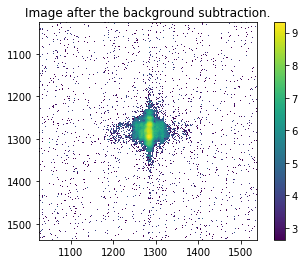

Background of 2050 counts has been subtracted.


In [30]:
ks.subtract_background(counts = 2050, 
                       estimate_only=False,
                       zoom = 5,
                       log_scale = True)

### Renormalisation (Parseval's theorem) <a class="anchor" id="renormalisation"></a>

Now when both images are correctly sampled and have equal linear number of pixels $N$, we must renormalise one of them to fulfill Parseval's theorem:

$\sum_{i}^{N-1}\sum_{j}^{N-1} |x[i,j]|^2  = \frac{1}{N^2} \sum_{m}^{N-1}\sum_{n}^{N-1} |X[m,n]|^2 $, (2)


where $i,j$ refer to the object space coordinates and $m,n$ to the Fourier space coordinates.

We renormalise the Fourier-domain image.

Compute energy in the object domain

In [31]:
energy_rspace = sum(sum(rs.image))
print(energy_rspace)

27958171.58832577


Renormalise in the Fourier domain.

In [32]:
ks.renormalise_image(energy_rspace)

Energy in Fourier domain: 183799704006126.1
Energy in object's domain * total number of pixels:  183799704006126.1
Fourier domain image has been renormalised. Parseval's theorem is fulfilled.


Equation (2) is now fulfilled.

## Saving processed images <a class="anchor" id="saving-processed-images"></a>

Processed images can be saved using ```save_as_tif``` method of the classes ```RSpaceImage```and ```KSpaceImage```. A user must enter a filename and will be asked for a path to save the data. The data will be saved as float32 data type.

In [35]:
ks.save_as_tif(pathtosave=datapath, outputfilename="KS_processed.tif")


The image was saved in tif file. Its metadata was saved in csv file.


/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/kspaceimage.py:575: UserWarning: /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/KS_processed.tif is a low contrast image
  io.imsave(os.path.join(pathtosave, outputfilename), self.image.astype(np.float32))


In [36]:
rs.save_as_tif(pathtosave=datapath, outputfilename="RS_processed.tif")

The image was saved in tif file. Its metadata was saved in csv file.


/Users/Pavel/Documents/repos/PhaseRetrieval/PhaseRetrieval/classes/rspaceimage.py:569: UserWarning: /Users/Pavel/Documents/repos/PhaseRetrieval/docs/data/RS_processed.tif is a low contrast image
  io.imsave(os.path.join(pathtosave, outputfilename), imagetosave.astype(np.float32))


## Phase retrieval from two intensity measurements <a class="anchor" id="phase-retrieval-from-two-intensity-measurements"></a>

## Phase retrieval from the modulus of Fourier transform data <a class="anchor" id="phase-retrieval-from-the-modulus-of-fourier-transform-data"></a>